Implementation of fine-tuned SciBERT language model for article section classification

In [1]:
from scipy.sparse import linalg
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import transformers
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, TableTransformerPreTrainedModel, Trainer
import evaluate
from transformers import DataCollatorWithPadding
from datasets import Dataset, DatasetDict
from torch.utils.data import DataLoader

device = torch.device('cuda')

c:\Users\larsg\Downloads\inted2025\plsworkenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Retrieving and reformatting data to suit our needs

In [23]:
url = 'processed_embeddings_light_20250702_142821.pkl'
df = pd.read_pickle(url)

In [24]:
data = df[['section_title_raw', 'content_text']].copy()

In [ ]:
import re

# Function to remove Roman numeral and title from the start of content_text
def clean_content(text, title):
    pattern = rf'^\s*[IVXLCDM]+\.\s*{re.escape(title)}\s*'
    return re.sub(pattern, '', text, flags=re.IGNORECASE).strip()

# Apply to your DataFrame
data['cleaned_content_text'] = data.apply(
    lambda row: clean_content(row['content_text'], row['section_title_raw'])
    if isinstance(row['content_text'], str) and isinstance(row['section_title_raw'], str)
    else row['content_text'],
    axis=1
)

label_groups = {
    0: ['INTRODUCTION'],
    1: ['METHODS', 'METHODOLOGY', 'METHOD'],
    2: ['DATA AND RESULTS', 'RESULTS', 'FINDINGS'],
    3: ['DISCUSSION', 'DISCUSSION AND CONCLUSIONS'],
    4: ['CONCLUDING REMARKS', 'CONCLUSION', 'CONCLUSIONS'],
    5: ['THEORY', 'BACKGROUND', 'THEORETICAL FRAMEWORK', 'THEORETICAL BACKGROUND', 'LITERATURE REVIEW'],
}


# Flatten the dictionary to title -> label
section_label_map = {
    title: label for label, titles in label_groups.items() for title in titles
}
data['section_label'] = data['section_title_raw'].apply(
    lambda title: section_label_map.get(title, -1)  # -1 for unknown titles
)


data = data[data['section_label'] != -1]

limit = np.min(data['section_label'].value_counts())
print(limit)

data = (
    data.groupby('section_label', group_keys=False)
    .apply(lambda x: x.sample(n=limit, random_state=42))
    .reset_index(drop=True)
)
canonical_section_titles = {
    0: 'INTRODUCTION',
    1: 'METHODS',
    2: 'RESULTS',
    3: 'DISCUSSION',
    4: 'CONCLUSION',
    5: 'THEORY'
}
data['canonical_section_title'] = data['section_label'].map(canonical_section_titles)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)


341


C:\Users\larsg\AppData\Local\Temp\ipykernel_20164\4017070859.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=limit, random_state=42))


Showcase data

In [26]:
data

,section_title_raw,content_text,cleaned_content_text,section_label,canonical_section_title
0,INTRODUCTION,"I. INTRODUCTION The concept examination, descr...","The concept examination, described here, grew ...",0,INTRODUCTION
1,DISCUSSION,IV. DISCUSSION This study showed that a studen...,This study showed that a student’s knowledge o...,3,DISCUSSION
2,METHODOLOGY,III. METHODOLOGY A. Workflow and study-specifi...,A. Workflow and study-specific additional step...,1,METHODS
3,METHODS,II. METHODS We used a qualitative methodologic...,We used a qualitative methodological approach ...,1,METHODS
4,CONCLUSION,"VIII. CONCLUSION In conclusion, we find that f...","In conclusion, we find that for students with ...",4,CONCLUSION
...,...,...,...,...,...
2041,DISCUSSION,VII. DISCUSSION There were four themes that we...,There were four themes that were salient when ...,3,DISCUSSION
2042,DISCUSSION AND CONCLUSIONS,V. DISCUSSION AND CONCLUSIONS This paper illus...,This paper illustrates a multilayered process ...,3,DISCUSSION
2043,RESULTS,III. RESULTS A. Content aspect of validity The...,A. Content aspect of validity The primary assi...,2,RESULTS
2044,CONCLUSIONS,VIII. CONCLUSIONS Researchers comparing in-per...,Researchers comparing in-person labs to remote...,4,CONCLUSION


In [ ]:
#data_processed = data[['cleaned_content_text', 'section_label', 'canonical_section_title']].copy()
data_processed = pd.read_csv(r'C:\Users\larsg\Downloads\inted2025\processed_section_data.csv')
data_processed


,cleaned_content_text,section_label,canonical_section_title
0,"The concept examination, described here, grew ...",0,INTRODUCTION
1,This study showed that a student’s knowledge o...,3,DISCUSSION
2,A. Workflow and study-specific additional step...,1,METHODS
3,We used a qualitative methodological approach ...,1,METHODS
4,"In conclusion, we find that for students with ...",4,CONCLUSION
...,...,...,...
2041,There were four themes that were salient when ...,3,DISCUSSION
2042,This paper illustrates a multilayered process ...,3,DISCUSSION
2043,A. Content aspect of validity The primary assi...,2,RESULTS
2044,Researchers comparing in-person labs to remote...,4,CONCLUSION


Instantiating model and tokenizer. Several LLMs were tested.

In [ ]:
    # pre-trained model path
#model_path = "allenai/scibert_base_uncased"
#model_path = 'google-bert/bert-base-uncased'
#model_path = 'google-bert/bert-large-uncased
#model_path = 'thellert/physbert_cased'
# load tokenizer

#tokenizer = AutoTokenizer.from_pretrained(model_path)

id2label = {
    0: 'INTRODUCTION',
    1: 'METHODS',
    2: 'RESULTS',
    3: 'DISCUSSION',
    4: 'CONCLUSION',
    5: 'THEORY'
}
label2id = {v: k for k, v in id2label.items()}

#allenai/scibert_scivocab_uncased
tokenizer = AutoTokenizer.from_pretrained(r'C:\Users\larsg\Downloads\inted2025\scibert_section_classifier\checkpoint-1790')
model = AutoModelForSequenceClassification.from_pretrained(r'C:\Users\larsg\Downloads\inted2025\scibert_section_classifier\checkpoint-1790', num_labels = 6, id2label=id2label, label2id=label2id)

Divide data into training-testing-validation-splits, preparing evaluation metrics and defining Hugging Face "trainer" instance with fitting hyperparameters.

In [60]:
%pip install --upgrade "accelerate>=0.26.0"

from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, log_loss

# freeze majority of model layers (we are only doing transfer learning/fine-tuning)
for name, param in model.base_model.named_parameters():
  if 'pooler' not in name:
    param.requires_grad = False

# text --> token preprocessing function (truncation to reduce necessary computational power)

# splitting data into train, test
seed = 2025
train_text, temp_text, train_labels, temp_labels, = train_test_split(data_processed['cleaned_content_text'], data_processed['section_label'], random_state = seed, test_size=0.3)
test_text, val_text, test_labels, val_labels = train_test_split(temp_text, temp_labels, random_state = seed, test_size=0.5)

#for data in [train_text, test_text, val_text]:
#  data = Dataset.from_pandas(data)

tokenized_train = tokenizer(train_text.tolist(), truncation = True, padding = True, max_length=512)
tokenized_test = tokenizer(test_text.tolist(), truncation = True, padding = True, max_length=512)
tokenized_val = tokenizer(val_text.tolist(), truncation = True, padding = True, max_length=512)

# converting to list format
train_labels = list(train_labels)
test_labels = list(test_labels)
val_labels = list(val_labels)

# add labels to the tokenized data
tokenized_train["labels"] = train_labels
tokenized_test["labels"] = test_labels
tokenized_val["labels"] = val_labels

# convert to Hugging Face Dataset format
train_dataset = Dataset.from_dict(tokenized_train)
test_dataset = Dataset.from_dict(tokenized_test)
val_dataset = Dataset.from_dict(tokenized_val)

# data collator to ensure uniform length of data
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# model evaluation
accuracy = evaluate.load('accuracy')

def compute_metrics(pred):
  # predictions
  preds, labels = pred

  # convert logits to probabilities
  prob = np.exp(preds) / np.exp(preds).sum(-1, keepdims = True)

  # predict most probable outcome
  predicted_outcome = np.argmax(preds, axis = 1)
  # accuracy
  acc = np.round(accuracy.compute(predictions=predicted_outcome, references = labels)['accuracy'], 3)

  return {"accuracy": acc}


def compute_metrics_full(pred):
    logits, labels = pred
    prob = np.exp(logits) / np.exp(logits).sum(-1, keepdims=True)
    predicted = np.argmax(logits, axis=1)

    acc = accuracy_score(labels, predicted)
    precision_w, recall_w, f1_w, _ = precision_recall_fscore_support(
        labels, predicted, average='weighted', zero_division=0
    )
    precision_c, recall_c, f1_c, support_c = precision_recall_fscore_support(
        labels, predicted, average=None, zero_division=0
    )
    ll = log_loss(labels, prob, labels=np.unique(labels)) if len(np.unique(labels)) > 1 else np.nan
    confidence = np.mean(np.max(prob, axis=1))
    entropy = -np.mean(np.sum(prob * np.log(prob + 1e-12), axis=1))

    metrics = {
        'accuracy': round(acc, 3),
        'precision_weighted': round(precision_w, 3),
        'recall_weighted': round(recall_w, 3),
        'f1_weighted': round(f1_w, 3),
        'log_loss': round(ll, 3),
        'avg_confidence': round(confidence, 3),
        'avg_entropy': round(entropy, 3)
    }

    for i in range(len(precision_c)):
        metrics[f'precision_class_{i}'] = round(precision_c[i], 3)
        metrics[f'recall_class_{i}'] = round(recall_c[i], 3)
        metrics[f'f1_class_{i}'] = round(f1_c[i], 3)
        metrics[f'support_class_{i}'] = int(support_c[i])

    return metrics

def compute_metrics2(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": round(acc, 3)}
  
# define training parameters
lr = 2e-4
batch_size = 8
epochs = 10

# define training arguments
training_args = TrainingArguments(
    output_dir='physBert-finetuned',
    learning_rate = lr,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    num_train_epochs = epochs,
    logging_strategy = 'epoch',
    eval_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True,
)
# define "trainer" instance
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer = tokenizer,
    data_collator = data_collator,
    compute_metrics = compute_metrics_full,
)


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\Users\larsg\AppData\Local\Temp\ipykernel_20164\2278242128.py:120: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Model training

In [5]:
tokenized_data = pd.read_csv("processed_section_data_embedded.csv").to_numpy()
data_processed = pd.read_csv("processed_section_data.csv")
#mask = data_processed['section_label'] != 5
mask = data_processed['section_label'].isin([0, 1])

seed = 2025
train_text, temp_text, train_labels, temp_labels, = train_test_split(data_processed[mask]['cleaned_content_text'], data_processed[mask]['section_label'], random_state = seed, test_size=0.3)
test_text, val_text, test_labels, val_labels = train_test_split(temp_text, temp_labels, random_state = seed, test_size=0.5)

#for data in [train_text, test_text, val_text]:
#  data = Dataset.from_pandas(data)

tokenized_train = tokenizer(train_text.tolist(), truncation = True, padding = True, max_length=512)
tokenized_test = tokenizer(test_text.tolist(), truncation = True, padding = True, max_length=512)
tokenized_val = tokenizer(val_text.tolist(), truncation = True, padding = True, max_length=512)

# converting to list format
train_labels = list(train_labels)
test_labels = list(test_labels)
val_labels = list(val_labels)

# add labels to the tokenized data
tokenized_train["labels"] = train_labels
tokenized_test["labels"] = test_labels
tokenized_val["labels"] = val_labels

# convert to Hugging Face Dataset format
train_dataset = Dataset.from_dict(tokenized_train)
test_dataset = Dataset.from_dict(tokenized_test)
val_dataset = Dataset.from_dict(tokenized_val)

# data collator to ensure uniform length of data
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# model evaluation
accuracy = evaluate.load('accuracy')

def compute_metrics(pred):
  # predictions
  preds, labels = pred

  # convert logits to probabilities
  prob = np.exp(preds) / np.exp(preds).sum(-1, keepdims = True)

  # predict most probable outcome
  predicted_outcome = np.argmax(preds, axis = 1)
  # accuracy
  acc = np.round(accuracy.compute(predictions=predicted_outcome, references = labels)['accuracy'], 3)

  return {"accuracy": acc}

def compute_metrics2(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": round(acc, 3)}
  
# define training parameters
lr = 2e-4
batch_size = 8
epochs = 10

# define training arguments
training_args = TrainingArguments(
    output_dir='psiBert-[0, 1]',
    learning_rate = lr,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    num_train_epochs = epochs,
    logging_strategy = 'epoch',
    eval_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True,
)
# define "trainer" instance
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer = tokenizer,
    data_collator = data_collator,
    compute_metrics = compute_metrics,
)


C:\Users\larsg\AppData\Local\Temp\ipykernel_20164\1278497924.py:76: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [19]:
trainer.train()

c:\Users\larsg\Downloads\inted2025\plsworkenv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.696200,0.744461,0.461000
2,0.717700,0.719668,0.461000
3,0.728200,0.735862,0.461000


c:\Users\larsg\Downloads\inted2025\plsworkenv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\larsg\Downloads\inted2025\plsworkenv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\larsg\Downloads\inted2025\plsworkenv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


KeyboardInterrupt: 

Model evaluation (general/per class)

In [64]:
# validation

predictions = trainer.predict(val_dataset)

logits = predictions.predictions
labels = predictions.label_ids

metrics = compute_metrics_full((logits, labels))
print(metrics)

c:\Users\larsg\Downloads\inted2025\plsworkenv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'accuracy': 0.772, 'precision_weighted': 0.791, 'recall_weighted': 0.772, 'f1_weighted': 0.776, 'log_loss': 0.646, 'avg_confidence': np.float32(0.75), 'avg_entropy': np.float32(0.645), 'precision_class_0': np.float64(0.759), 'recall_class_0': np.float64(0.721), 'f1_class_0': np.float64(0.739), 'support_class_0': 61, 'precision_class_1': np.float64(0.933), 'recall_class_1': np.float64(0.808), 'f1_class_1': np.float64(0.866), 'support_class_1': 52, 'precision_class_2': np.float64(0.785), 'recall_class_2': np.float64(0.911), 'f1_class_2': np.float64(0.843), 'support_class_2': 56, 'precision_class_3': np.float64(0.809), 'recall_class_3': np.float64(0.731), 'f1_class_3': np.float64(0.768), 'support_class_3': 52, 'precision_class_4': np.float64(0.906), 'recall_class_4': np.float64(0.707), 'f1_class_4': np.float64(0.795), 'support_class_4': 41, 'precision_class_5': np.float64(0.55), 'recall_class_5': np.float64(0.733), 'f1_class_5': np.float64(0.629), 'support_class_5': 45}


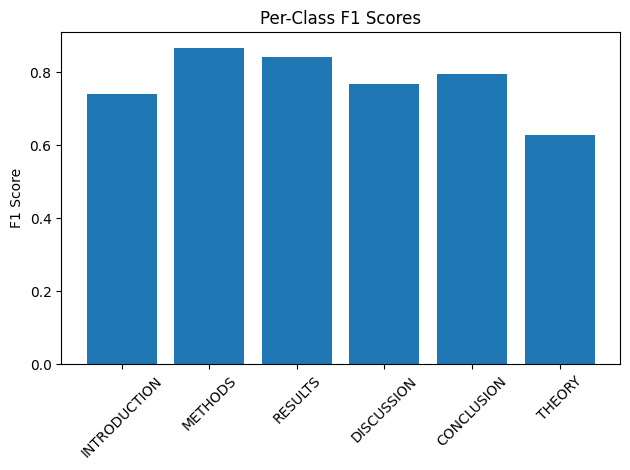

In [65]:
import matplotlib.pyplot as plt

labels1 = list(range(6))
f1_scores = [metrics[f'f1_class_{i}'] for i in labels1]

plt.bar(labels1, f1_scores)
plt.xticks(labels1, [id2label[i] for i in labels1], rotation=45)
plt.title("Per-Class F1 Scores")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

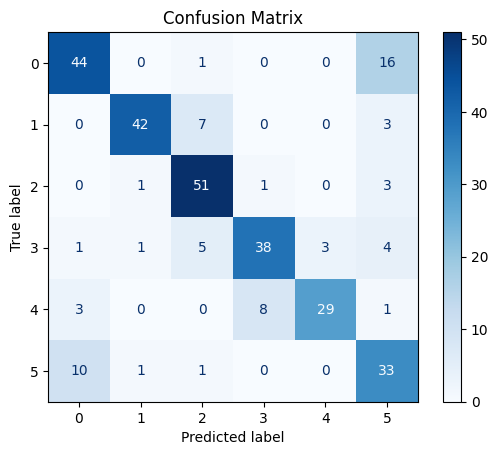

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(preds, labels, class_names=None):
    # convert logits to probabilities
    predicted_outcome = np.argmax(preds, axis=1)

    # generate confusion matrix
    cm = confusion_matrix(labels, predicted_outcome)

    # plot confusion matrix
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d')

    plt.title("Confusion Matrix")
    plt.show()
    
plot_confusion_matrix(logits, labels)

AttributeError: 'numpy.ndarray' object has no attribute 'set_fontsize'

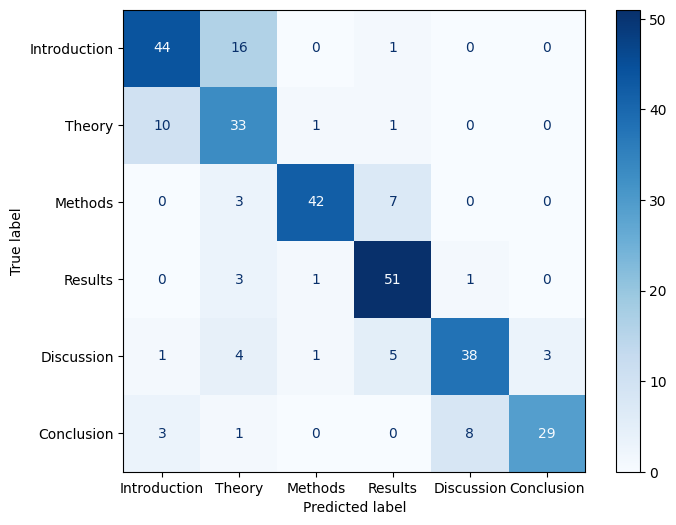

In [68]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def plot_confusion_matrix_reordered(preds, labels, original_classes, reordered_classes):
    # Map the original labels to their new positions
    reorder_map = {old: new for new, old in enumerate(reordered_classes)}

    # Apply the reordering to labels and predictions
    reordered_labels = [reorder_map[label] for label in labels]
    predicted_outcome = np.argmax(preds, axis=1)
    reordered_preds = [reorder_map[pred] for pred in predicted_outcome]

    # Generate confusion matrix
    cm = confusion_matrix(reordered_labels, reordered_preds)

    # Create label names in new order
    class_names = [original_classes[i] for i in reordered_classes]

    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d', ax=ax)

    # Reduce font size for tick labels
    ax.tick_params(axis='both', which='major', labelsize=10)

    # Optional: reduce font size for text in cells
    for text in disp.text_:
        text.set_fontsize(10)

    plt.title("Confusion Matrix (Class 5 Reordered)", fontsize=12)
    plt.tight_layout()
    plt.show()

# Define original and desired class orders
original_classes = ['Introduction', 'Methods', 'Results', 'Discussion', 'Conclusion', 'Theory']
reordered_classes = [0, 5, 1, 2, 3, 4]

plot_confusion_matrix_reordered(logits, labels, original_classes, reordered_classes)
